#Building an LSTM neural network

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import print_function

# import local library
import tools
import nnlstm

# import library to build the neural network
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam

Let's gather the datas from the previous notebook

In [2]:
X_train, y_train, X_test, y_test, feature_names, max_features, classes_names, vectorizer = tools.load_pickle("data/unpadded_4_BacObjMetCon.pickle")

Loading 'data/unpadded_4_BacObjMetCon.pickle'...
Done. [0.22s]


and pad each vector to a regular size

In [3]:
X_train, X_test, y_train, y_test = nnlstm.pad_sequence(X_train, X_test, y_train, y_test, maxlen=100)

Pading sequences...
X_train shape: (1427, 100)
X_test shape: (357, 100)
Done. [0.02s]


Or get a big one:

In [23]:
X_train, y_train, X_test, y_test, feature_names, max_features, classes_names, vectorizer = tools.load_pickle("data/training_4_BacObjMetCon.pickle")

Loading 'data/training_4_BacObjMetCon.pickle'...
Done. [4.32s]


Our data look like this:

In [24]:
X_train[0]

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,    110,    168,     84,
       174729,  73766,  25389, 174840, 104175,  31078,  52214, 174840,
       104175, 138222,  12522, 156117], dtype=int32)

In [25]:
# one-hot vector for the 4 different labels
y_train[0]

array([ 0.,  0.,  0.,  1.])

#Choosing the architecture

We use the [Keras](https://github.com/fchollet/keras) library, build on [Theano](https://github.com/Theano/Theano).

Here I choose a very simple architecture because of my low performance system (with no graphic card), but feel free try any. Especially, stacking layers of LSTM could improve performance, according to [this paper](http://arxiv.org/abs/1506.02078) from Karpathy (which I used a lot as reference by the way)

In [27]:
%%time
# take approximately 50s to build
dim_out = len(classes_names)

net = Sequential()
net.add(Embedding(max_features, 16))
net.add(LSTM(16, 16))
net.add(Dense(16, dim_out))
net.add(Dropout(0.5))
net.add(Activation('softmax'))
net.compile(loss='categorical_crossentropy', optimizer='adam', class_mode="categorical")

CPU times: user 54.5 s, sys: 661 ms, total: 55.2 s
Wall time: 56.3 s


In [28]:
batch_size   = 100
length_train = 15000  # length of the reduced training set (can put to -1 for all)
length_test  = 5000   # length of the reduced testing set  (can put to -1 for all)
nb_epoch     = 10
patience     = 2      # when to apply early stopping, if necessary
history = nnlstm.train_network(net,
                        X_train[:length_train],
                        y_train[:length_train],
                        X_test[:length_test],
                        y_test[:length_test],
                        nb_epoch,
                        batch_size=batch_size,
                        path_save="weights",
                        patience=patience) 

Training...
Train on 15000 samples, validate on 5000 samples
Epoch 0
15000/15000 [==============================] - 24s - loss: 1.2798 - acc: 0.3768 - val_loss: 1.1028 - val_acc: 0.5908
Saving at first epoch
Epoch 1
15000/15000 [==============================] - 24s - loss: 1.0243 - acc: 0.4921 - val_loss: 0.8409 - val_acc: 0.6676
Model improved, saving weight
Epoch 2
15000/15000 [==============================] - 25s - loss: 0.9230 - acc: 0.5090 - val_loss: 0.7573 - val_acc: 0.6646
Model improved, saving weight
Epoch 3
15000/15000 [==============================] - 28s - loss: 0.8712 - acc: 0.5310 - val_loss: 0.7072 - val_acc: 0.6726
Model improved, saving weight
Epoch 4
15000/15000 [==============================] - 27s - loss: 0.8411 - acc: 0.5379 - val_loss: 0.6854 - val_acc: 0.6738
Model improved, saving weight
Epoch 5
15000/15000 [==============================] - 24s - loss: 0.8274 - acc: 0.5412 - val_loss: 0.6614 - val_acc: 0.6838
Model improved, saving weight
Epoch 6
15000/150

The **weights are saved at each epoch**, and you can load '`best`' for the epoch with the higher (accuracy * (loss/10))

In [29]:
net.load_weights("weights/best.hdf5")

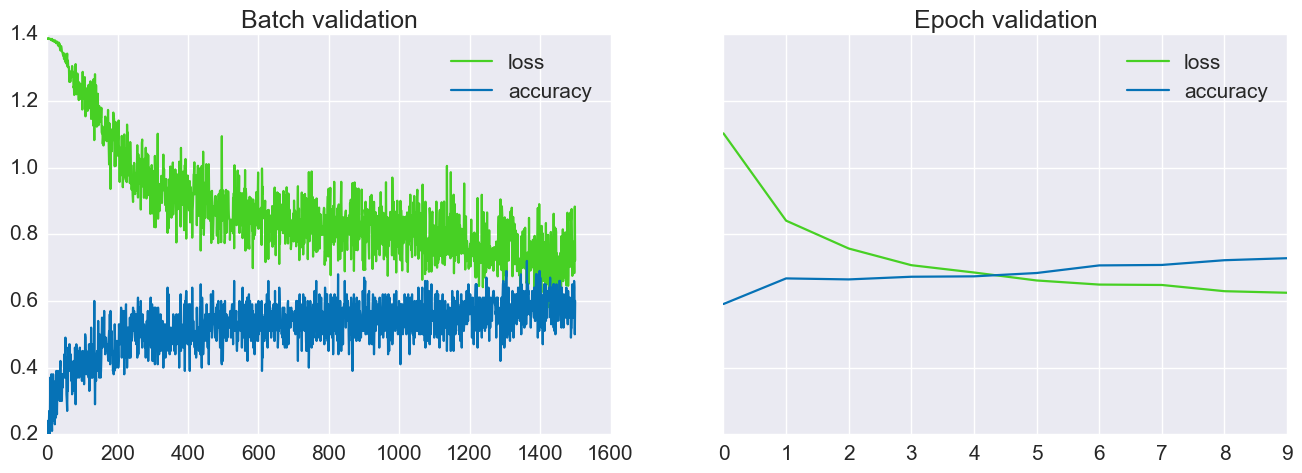

In [30]:
nnlstm.show_history(history)

#Evaluate the network

No decision: 0 / 383460  [0.00%]0 0
Accuracy: 0.850693
             precision    recall  f1-score   support

 BACKGROUND       0.50      0.51      0.51     92794
  OBJECTIVE       0.52      0.53      0.53     93136
     METHOD       0.89      0.84      0.86    101760
 CONCLUSION       0.98      0.98      0.98     95770

avg / total       0.73      0.72      0.72    383460

Confusion matrix:
[[47774 37517  6986   517]
 [39959 49756  2840   581]
 [ 8224  7996 85013   527]
 [  152   856  1008 93754]]


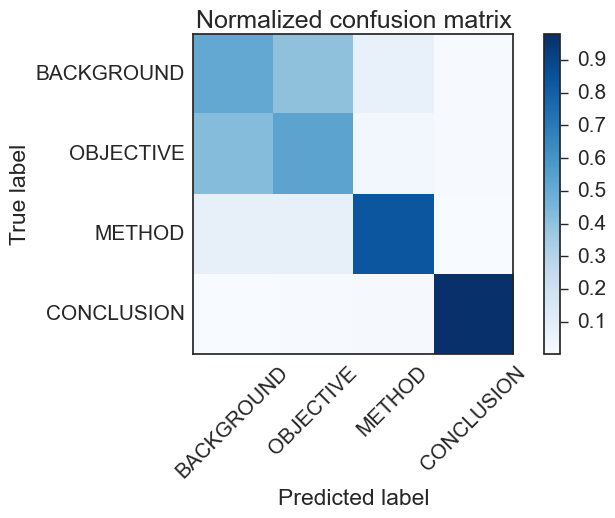

In [31]:
nnlstm.evaluate_network(net, X_test[:length_test], y_test[:length_test], classes_names, length=-1)